In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch

In [2]:
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.repository.datasets import dataset_recipes, get_dataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import MultivariateEvaluator

from MlpTSMixer import MlpTSMixerEstimator

/home/kashif/.env/pytorch/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/kashif/.env/pytorch/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c106detail23torchInternalAssertFailEPKcS2_jS2_RKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
dataset = get_dataset("solar_nips", regenerate=False)
train_grouper = MultivariateGrouper(max_target_dim=int(dataset.metadata.feat_static_cat[0].cardinality))

test_grouper = MultivariateGrouper(num_test_dates=int(len(dataset.test)/len(dataset.train)), 
                                   max_target_dim=int(dataset.metadata.feat_static_cat[0].cardinality))
dataset_train = train_grouper(dataset.train)
dataset_test = test_grouper(dataset.test)

In [4]:
estimator = MlpTSMixerEstimator(
    #distr_output=StudentTOutput(dim=int(dataset.metadata.feat_static_cat[0].cardinality)),
    input_size=int(dataset.metadata.feat_static_cat[0].cardinality),
    
    prediction_length=dataset.metadata.prediction_length,
    context_length=dataset.metadata.prediction_length*5,
    freq=dataset.metadata.freq,
    scaling="std",
    
    depth=4,
    patch_size=(11, 11),
    dim=32,
    
    batch_size=128,
    num_batches_per_epoch=100,
    trainer_kwargs=dict(accelerator="cuda")
)

In [5]:
predictor = estimator.train(
    training_data=dataset_train, 
    cache_data=True, 
    shuffle_buffer_length=1024, 
)

Authorization required, but no authorization protocol specified
Authorization required, but no authorization protocol specified
Authorization required, but no authorization protocol specified
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:72: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
You are using a CUDA device ('NVIDIA GeForce RTX 3090 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Ty

Training: 0it [00:00, ?it/s]

Epoch 0, global step 100: 'train_loss' reached 4.36400 (best 4.36400), saving model to '/mnt/scratch/kashif/ConvTS-Mixer/lightning_logs/version_111/checkpoints/epoch=0-step=100.ckpt' as top 1
Epoch 1, global step 200: 'train_loss' reached 3.87802 (best 3.87802), saving model to '/mnt/scratch/kashif/ConvTS-Mixer/lightning_logs/version_111/checkpoints/epoch=1-step=200.ckpt' as top 1
Epoch 2, global step 300: 'train_loss' reached 3.75643 (best 3.75643), saving model to '/mnt/scratch/kashif/ConvTS-Mixer/lightning_logs/version_111/checkpoints/epoch=2-step=300.ckpt' as top 1
Epoch 3, global step 400: 'train_loss' reached 3.69363 (best 3.69363), saving model to '/mnt/scratch/kashif/ConvTS-Mixer/lightning_logs/version_111/checkpoints/epoch=3-step=400.ckpt' as top 1
Epoch 4, global step 500: 'train_loss' reached 3.64691 (best 3.64691), saving model to '/mnt/scratch/kashif/ConvTS-Mixer/lightning_logs/version_111/checkpoints/epoch=4-step=500.ckpt' as top 1
Epoch 5, global step 600: 'train_loss' w

Epoch 68, global step 6900: 'train_loss' was not in top 1
Epoch 69, global step 7000: 'train_loss' reached 3.36674 (best 3.36674), saving model to '/mnt/scratch/kashif/ConvTS-Mixer/lightning_logs/version_111/checkpoints/epoch=69-step=7000.ckpt' as top 1
Epoch 70, global step 7100: 'train_loss' was not in top 1
Epoch 71, global step 7200: 'train_loss' was not in top 1
Epoch 72, global step 7300: 'train_loss' was not in top 1
Epoch 73, global step 7400: 'train_loss' was not in top 1
Epoch 74, global step 7500: 'train_loss' was not in top 1
Epoch 75, global step 7600: 'train_loss' was not in top 1
Epoch 76, global step 7700: 'train_loss' was not in top 1
Epoch 77, global step 7800: 'train_loss' was not in top 1
Epoch 78, global step 7900: 'train_loss' was not in top 1
Epoch 79, global step 8000: 'train_loss' was not in top 1
Epoch 80, global step 8100: 'train_loss' was not in top 1
Epoch 81, global step 8200: 'train_loss' was not in top 1
Epoch 82, global step 8300: 'train_loss' reached 3

In [6]:
forecast_it, ts_it = make_evaluation_predictions(dataset=dataset_test,
                                             predictor=predictor,
                                             num_samples=100)
forecasts = list(forecast_it)
targets = list(ts_it)

In [7]:
evaluator = MultivariateEvaluator(quantiles=(np.arange(20)/20.0)[1:],
                                  target_agg_funcs={'sum': np.sum})

In [8]:
agg_metric, _ = evaluator(targets, forecasts, num_series=len(dataset_test))

Running evaluation: 7it [00:00, 92.96it/s]
Running evaluation: 7it [00:00, 111.23it/s]
Running evaluation: 7it [00:00, 111.56it/s]
Running evaluation: 7it [00:00, 111.83it/s]
Running evaluation: 7it [00:00, 111.46it/s]
Running evaluation: 7it [00:00, 111.91it/s]
Running evaluation: 7it [00:00, 111.83it/s]
Running evaluation: 7it [00:00, 112.32it/s]
Running evaluation: 7it [00:00, 111.89it/s]
Running evaluation: 7it [00:00, 111.32it/s]
Running evaluation: 7it [00:00, 112.67it/s]
Running evaluation: 7it [00:00, 113.21it/s]
Running evaluation: 7it [00:00, 112.10it/s]
Running evaluation: 7it [00:00, 111.86it/s]
Running evaluation: 7it [00:00, 111.59it/s]
Running evaluation: 7it [00:00, 113.26it/s]
Running evaluation: 7it [00:00, 111.91it/s]
Running evaluation: 7it [00:00, 111.41it/s]
Running evaluation: 7it [00:00, 113.05it/s]
Running evaluation: 7it [00:00, 111.38it/s]
Running evaluation: 7it [00:00, 112.15it/s]
Running evaluation: 7it [00:00, 113.43it/s]
Running evaluation: 7it [00:00, 1

In [9]:
print("CRPS: {}".format(agg_metric['mean_wQuantileLoss']))
print("ND: {}".format(agg_metric['ND']))
print("NRMSE: {}".format(agg_metric['NRMSE']))
print("MSE: {}".format(agg_metric['MSE']))

CRPS: 0.3815311940581633
ND: 0.5344750930082028
NRMSE: 0.985216372580408
MSE: 920.7485175956485


In [10]:
def plot(target, forecast, prediction_length, prediction_intervals=(50.0, 90.0), color='g', fname=None):
    label_prefix = ""
    rows = 4
    cols = 4
    fig, axs = plt.subplots(rows, cols, figsize=(24, 24))
    axx = axs.ravel()
    seq_len, target_dim = target.shape
    
    ps = [50.0] + [
            50.0 + f * c / 2.0 for c in prediction_intervals for f in [-1.0, +1.0]
        ]
        
    percentiles_sorted = sorted(set(ps))
    
    def alpha_for_percentile(p):
        return (p / 100.0) ** 0.3
        
    for dim in range(0, min(rows * cols, target_dim)):
        ax = axx[dim]

        target[-2 * prediction_length :][dim].plot(ax=ax)
        
        ps_data = [forecast.quantile(p / 100.0)[:,dim] for p in percentiles_sorted]
        i_p50 = len(percentiles_sorted) // 2
        
        p50_data = ps_data[i_p50]
        p50_series = pd.Series(data=p50_data, index=forecast.index)
        p50_series.plot(color=color, ls="-", label=f"{label_prefix}median", ax=ax)
        
        for i in range(len(percentiles_sorted) // 2):
            ptile = percentiles_sorted[i]
            alpha = alpha_for_percentile(ptile)
            ax.fill_between(
                forecast.index,
                ps_data[i],
                ps_data[-i - 1],
                facecolor=color,
                alpha=alpha,
                interpolate=True,
            )
            # Hack to create labels for the error intervals.
            # Doesn't actually plot anything, because we only pass a single data point
            pd.Series(data=p50_data[:1], index=forecast.index[:1]).plot(
                color=color,
                alpha=alpha,
                linewidth=10,
                label=f"{label_prefix}{100 - ptile * 2}%",
                ax=ax,
            )

    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]    
    axx[0].legend(legend, loc="upper left")
    
    if fname is not None:
        plt.savefig(fname, bbox_inches='tight', pad_inches=0.05)

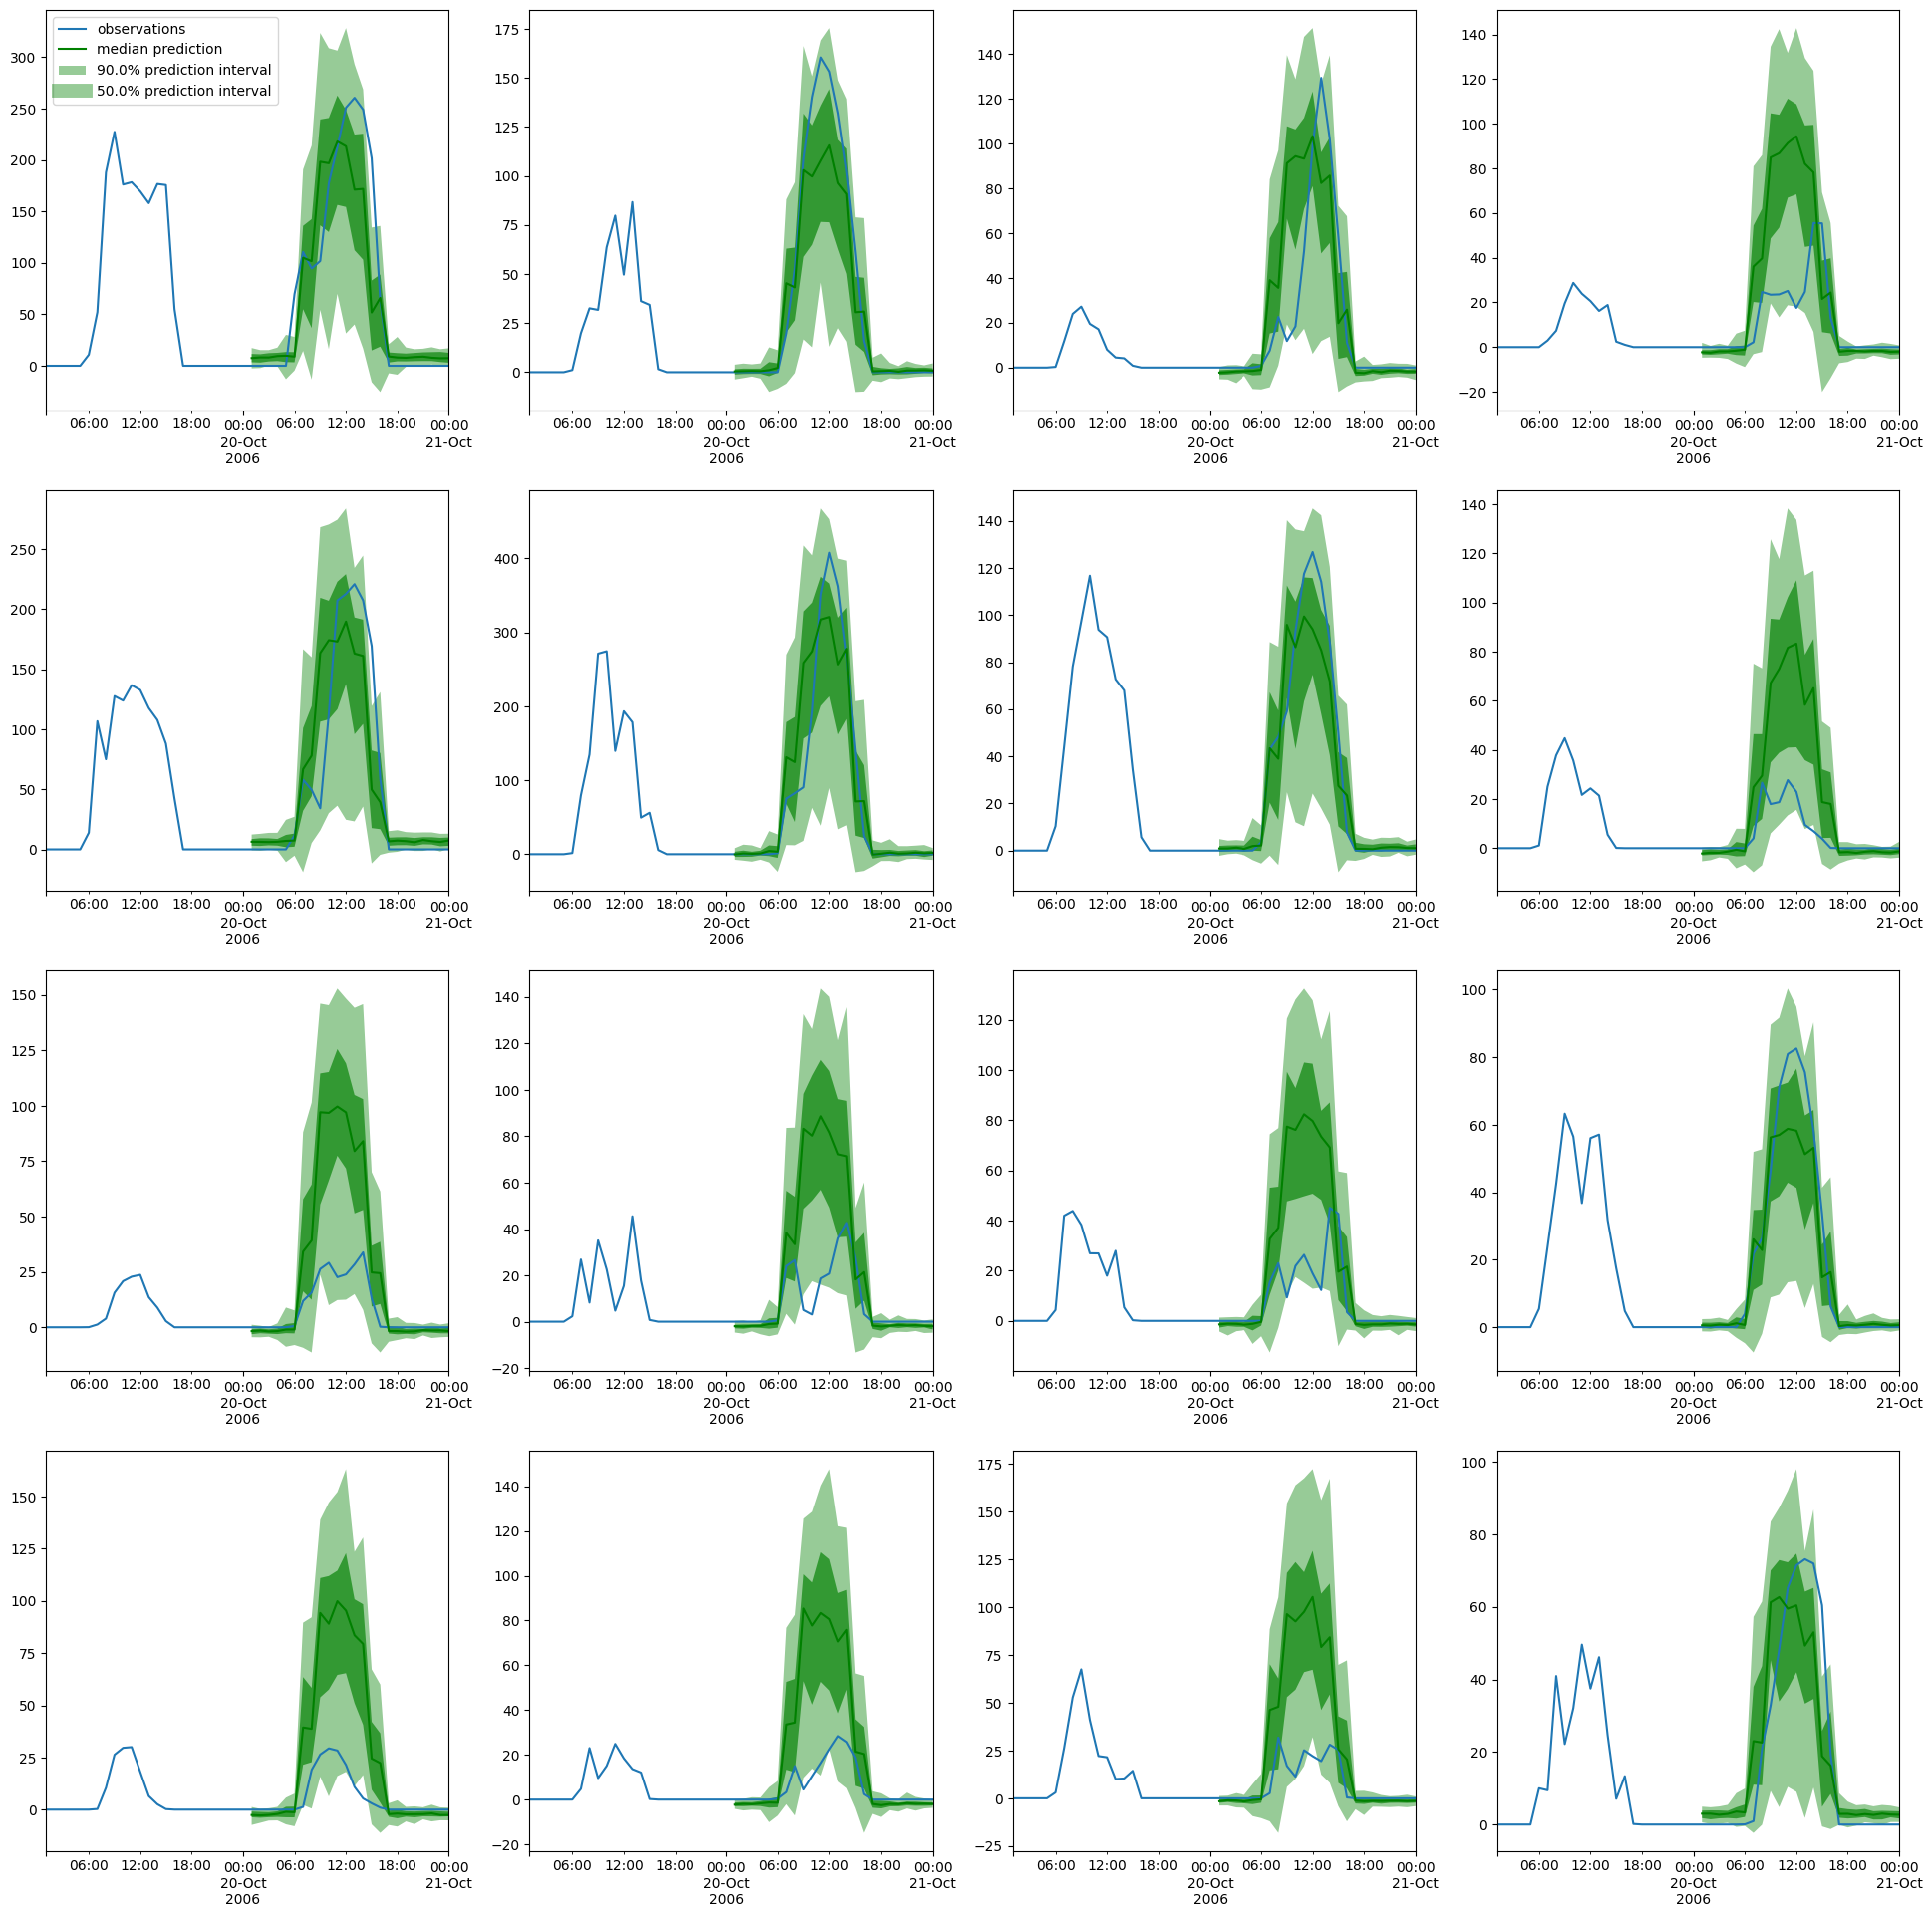

In [11]:
plot(
    target=targets[0],
    forecast=forecasts[0],
    prediction_length=dataset.metadata.prediction_length,
)
plt.show()